## Simulation on the fully synthetic regression task

In [1]:
from mechanism_learn import pipeline as mlpipe
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Load datasets

In [ ]:
syn_data_dir = r"../../test_data/synthetic_data/"
testcase_dir = r"syn_regression/"
X_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "X_train_conf.csv").to_numpy()
Y_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "Y_train_conf.csv").to_numpy().ravel()
Z_train_conf = pd.read_csv(syn_data_dir + testcase_dir + "Z_train_conf.csv").to_numpy()

X_train_unconf = pd.read_csv(syn_data_dir + testcase_dir + "X_train_unconf.csv").to_numpy()
Y_train_unconf = pd.read_csv(syn_data_dir + testcase_dir + "Y_train_unconf.csv").to_numpy().ravel()

X_test_conf = pd.read_csv(syn_data_dir + testcase_dir + "X_test_conf.csv").to_numpy()
Y_test_conf = pd.read_csv(syn_data_dir + testcase_dir + "Y_test_conf.csv").to_numpy().ravel()

X_test_unconf = pd.read_csv(syn_data_dir + testcase_dir + "X_test_unconf.csv").to_numpy()
Y_test_unconf = pd.read_csv(syn_data_dir + testcase_dir + "Y_test_unconf.csv").to_numpy().ravel()

# random sample 10000 from training set for faster training
idx_conf = np.random.choice(len(X_train_conf), 10000, replace=False)
X_train_conf = X_train_conf[idx_conf]
Y_train_conf = Y_train_conf[idx_conf]
Z_train_conf = Z_train_conf[idx_conf]

idx_unconf = np.random.choice(len(X_train_unconf), 10000, replace=False)
X_train_unconf = X_train_unconf[idx_unconf]
Y_train_unconf = Y_train_unconf[idx_unconf]

# random sample 5000 from testing set for faster evaluation
idx_conf_test = np.random.choice(len(X_test_conf), 5000, replace=False)
X_test_conf = X_test_conf[idx_conf_test]
Y_test_conf = Y_test_conf[idx_conf_test]

idx_unconf_test = np.random.choice(len(X_test_unconf), 5000, replace=False)
X_test_unconf = X_test_unconf[idx_unconf_test]
Y_test_unconf = Y_test_unconf[idx_unconf_test]

### Parameters

In [3]:
# Parameters for CWGMM
comp_k = 2
max_iter = 1000
tol = 1e-4
cov_type = 'full'
cov_reg = 1e-4
min_variance_value = 1e-5
init_method = 'kmeans++'
# Parameters for weights estimation
est_method = "multinorm"
N = X_train_conf.shape[0]
# Parameters for resampling (Counterfactual Intervention)
intv_intval_num = 50
Y_interv_values = np.linspace(Y_train_conf.min()*1.6, Y_train_conf.max()*1.3, intv_intval_num)
n_samples = [int(N // intv_intval_num)] * intv_intval_num
# Parameters for plotting
save_fig = False
save_dir = r"../../res_fig/"
figsize = (6, 11)
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["axes.titlesize"] = 16
title_size = 21
axis_label_fontsize = 18
x_range = (-40, 50)
y_range = (-10, 20)
dot_marker_size = 10
dot_alpha = 0.3
lw = 3
legend_fontsize = 14
legend_dot_size = 2
legend_frame_alpha = 0.3
legend_loc = "upper left"
color_map = {'confounded data': 'royalblue',
             'non-confounded data': 'mediumseagreen',
             'deconfounded data': 'dimgrey',
             'confounded regression line': 'red',
             'non-confounded regression line': 'black',
             'deconfounded regression line': 'red'}

### Train a deconfounded linear regressor using mechanism learning

In [4]:
ml_gmm_pipeline = mlpipe.mechanism_learning_process(cause_data = Y_train_conf,
                                                    mechanism_data = Z_train_conf, 
                                                    effect_data = X_train_conf, 
                                                    intv_values = Y_interv_values, 
                                                    dist_map = None, 
                                                    est_method = "multinorm"
                                                    )

ml_gmm_pipeline.cwgmm_fit(comp_k = comp_k,
                          max_iter = max_iter,
                          tol = tol,
                          init_method= init_method,
                          cov_type = cov_type,
                          cov_reg = cov_reg, 
                          min_variance_value=min_variance_value, 
                          verbose = 1)

deconf_X_gmm, deconf_Y_gmm = ml_gmm_pipeline.cwgmm_resample(n_samples = n_samples, return_samples = True)


CW-GMMs fitting:   0%|          | 0/50 [00:00<?, ?model/s]

In [5]:
deconf_gmm_lr = ml_gmm_pipeline.deconf_model_fit(ml_model = LinearRegression())

### Train a deconfounded linear regressor using CB-based deconfounding method

In [6]:
ml_cb_pipeline = mlpipe.mechanism_learning_process(cause_data = Y_train_conf,
                                                   mechanism_data = Z_train_conf, 
                                                   effect_data = X_train_conf, 
                                                   intv_values = Y_interv_values, 
                                                   dist_map = None, 
                                                   est_method = est_method
                                                   )

deconf_X_cb, deconf_Y_cb = ml_cb_pipeline.cb_resample(n_samples = n_samples,
                                                      return_samples = True)

CB Resampling:   0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
deconf_cb_lr = ml_cb_pipeline.deconf_model_fit(ml_model = LinearRegression())

### Train confounded and unconfounded linear regressors

In [8]:
conf_lr = LinearRegression()
conf_lr = conf_lr.fit(X_train_conf, Y_train_conf.reshape(-1))

In [9]:
unconf_lr = LinearRegression()
unconf_lr.fit(X_train_unconf, Y_train_unconf.reshape(-1))

LinearRegression()

### Compare their regression lines

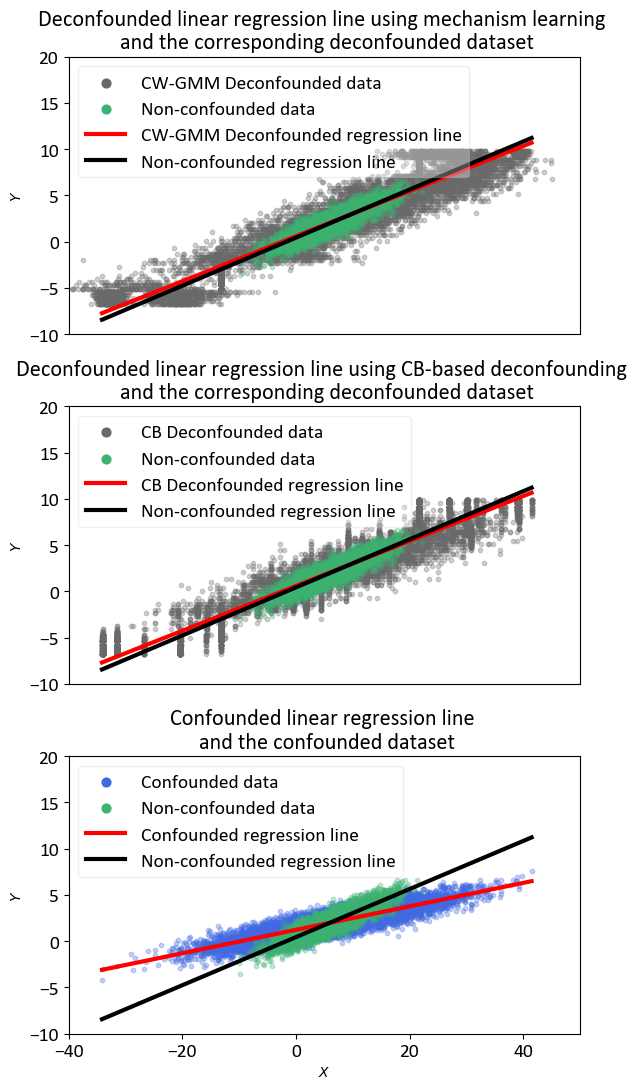

In [12]:
x_grid = np.linspace(np.min([np.min(X_train_conf), np.min(X_test_unconf)]),
                     np.max([np.max(X_train_conf), np.max(X_test_unconf)]), 
                     num=1000)
regLine_conf = conf_lr.predict(x_grid.reshape(-1,1))
regLine_deconf_gmm = deconf_gmm_lr.predict(x_grid.reshape(-1,1))
regLine_deconf_cb = deconf_cb_lr.predict(x_grid.reshape(-1,1))
regLine_unconf = unconf_lr.predict(x_grid.reshape(-1,1))


fig, axs = plt.subplots(3, 1, figsize=figsize)
# Plot deconfounded linear regression line on CW-GMM deconfounded dataset
ax = axs[0]
ax.scatter(deconf_X_gmm, deconf_Y_gmm, s=dot_marker_size, 
           c=color_map['deconfounded data'], alpha=dot_alpha, label="CW-GMM Deconfounded data")
ax.scatter(X_test_unconf, Y_test_unconf, s=dot_marker_size, 
           c=color_map['non-confounded data'], alpha=dot_alpha, label="Non-confounded data")
ax.plot(x_grid, regLine_deconf_gmm, 
        color=color_map['deconfounded regression line'], label="CW-GMM Deconfounded regression line", linewidth=lw)
ax.plot(x_grid, regLine_unconf, 
        color=color_map['non-confounded regression line'], label='Non-confounded regression line', linewidth=lw)
ax.set_ylabel(r"$Y$")
ax.set_xticks([])  
ax.set_ylim(y_range[0], y_range[1])
ax.set_xlim(x_range[0], x_range[1])
ax.set_title("Deconfounded linear regression line using mechanism learning \n and the corresponding deconfounded dataset")
legend = ax.legend(fontsize=legend_fontsize, loc=legend_loc, markerscale=legend_dot_size, framealpha=legend_frame_alpha)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)

# Plot deconfounded linear regression line on CB deconfounded dataset
ax = axs[1]
ax.scatter(deconf_X_cb, deconf_Y_cb, s=dot_marker_size, 
           c=color_map['deconfounded data'], alpha=dot_alpha, label="CB Deconfounded data")
ax.scatter(X_test_unconf, Y_test_unconf, s=dot_marker_size, 
           c=color_map['non-confounded data'], alpha=dot_alpha, label="Non-confounded data")
ax.plot(x_grid, regLine_deconf_cb, 
        color=color_map['deconfounded regression line'], label="CB Deconfounded regression line", linewidth=lw)
ax.plot(x_grid, regLine_unconf, 
        color=color_map['non-confounded regression line'], label='Non-confounded regression line', linewidth=lw)
ax.set_ylabel(r"$Y$")
ax.set_xticks([])  
ax.set_ylim(y_range[0], y_range[1])
ax.set_xlim(x_range[0], x_range[1])
ax.set_title("Deconfounded linear regression line using CB-based deconfounding \n and the corresponding deconfounded dataset")
legend = ax.legend(fontsize=legend_fontsize, loc=legend_loc, markerscale=legend_dot_size, framealpha=legend_frame_alpha)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)

# Plot confounded linear regression line on confounded dataset    
ax = axs[2]
ax.scatter(X_train_conf, Y_train_conf, s=dot_marker_size, 
           c=color_map['confounded data'], alpha=dot_alpha, label="Confounded data")
ax.scatter(X_test_unconf, Y_test_unconf, s=dot_marker_size, 
           c=color_map['non-confounded data'], alpha=dot_alpha, label="Non-confounded data")
ax.plot(x_grid, regLine_conf, 
        color=color_map['confounded regression line'], label="Confounded regression line", linewidth=lw)
ax.plot(x_grid, regLine_unconf, 
        color=color_map['non-confounded regression line'], label='Non-confounded regression line', linewidth=lw)
ax.set_ylabel(r"$Y$")
ax.set_xlabel(r"$X$")
ax.set_ylim(y_range[0], y_range[1])
ax.set_xlim(x_range[0], x_range[1])
ax.set_title("Confounded linear regression line \n and the confounded dataset")
legend = ax.legend(fontsize=legend_fontsize, loc=legend_loc, markerscale=legend_dot_size, framealpha=legend_frame_alpha)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)
plt.tight_layout()
plt.show()

### Compare thier performance on the confounded and non-confounded test datasets

In [11]:
# Preditction on the non-confounded test set
y_pred_gmm_deconf_unconf = deconf_gmm_lr.predict(X_test_unconf)
y_pred_cb_deconf_unconf = deconf_cb_lr.predict(X_test_unconf)
y_pred_conf_unconf = conf_lr.predict(X_test_unconf)
y_pred_unconf_unconf = unconf_lr.predict(X_test_unconf)
# Preditction on the confounded test set
y_pred_gmm_deconf_conf = deconf_gmm_lr.predict(X_test_conf)
y_pred_cb_deconf_conf = deconf_cb_lr.predict(X_test_conf)
y_pred_conf_conf = conf_lr.predict(X_test_conf)
y_pred_unconf_conf = unconf_lr.predict(X_test_conf)

mse_gmm_deconf_unconf = mean_squared_error(Y_test_unconf, y_pred_gmm_deconf_unconf)
r2_gmm_deconf_unconf = r2_score(Y_test_unconf, y_pred_gmm_deconf_unconf)
mae_gmm_deconf_unconf = mean_absolute_error(Y_test_unconf, y_pred_gmm_deconf_unconf)

mse_cb_deconf_unconf = mean_squared_error(Y_test_unconf, y_pred_cb_deconf_unconf)
r2_cb_deconf_unconf = r2_score(Y_test_unconf, y_pred_cb_deconf_unconf)
mae_cb_deconf_unconf = mean_absolute_error(Y_test_unconf, y_pred_cb_deconf_unconf)

mse_conf_unconf = mean_squared_error(Y_test_unconf, y_pred_conf_unconf)
r2_conf_unconf = r2_score(Y_test_unconf, y_pred_conf_unconf)
mae_conf_unconf = mean_absolute_error(Y_test_unconf, y_pred_conf_unconf)

mse_unconf_unconf = mean_squared_error(Y_test_unconf, y_pred_unconf_unconf)
r2_unconf_unconf = r2_score(Y_test_unconf, y_pred_unconf_unconf)
mae_unconf_unconf = mean_absolute_error(Y_test_unconf, y_pred_unconf_unconf)

mse_gmm_deconf_conf = mean_squared_error(Y_test_conf, y_pred_gmm_deconf_conf)
r2_gmm_deconf_conf = r2_score(Y_test_conf, y_pred_gmm_deconf_conf)
mae_gmm_deconf_conf = mean_absolute_error(Y_test_conf, y_pred_gmm_deconf_conf)

mse_cb_deconf_conf = mean_squared_error(Y_test_conf, y_pred_cb_deconf_conf)
r2_cb_deconf_conf = r2_score(Y_test_conf, y_pred_cb_deconf_conf)
mae_cb_deconf_conf = mean_absolute_error(Y_test_conf, y_pred_cb_deconf_conf)

mse_conf_conf = mean_squared_error(Y_test_conf, y_pred_conf_conf)
r2_conf_conf = r2_score(Y_test_conf, y_pred_conf_conf)
mae_conf_conf = mean_absolute_error(Y_test_conf, y_pred_conf_conf)

mse_unconf_conf = mean_squared_error(Y_test_conf, y_pred_unconf_conf)
r2_unconf_conf = r2_score(Y_test_conf, y_pred_unconf_conf)
mae_unconf_conf = mean_absolute_error(Y_test_conf, y_pred_unconf_conf)

print("Test on the non-confounded test set:")
print("deconfounded model using mechanism learning:")
print(f"MSE: {round(mse_gmm_deconf_unconf,3)}")
print(f"R2: {round(r2_gmm_deconf_unconf,3)}")
print(f"MAE: {round(mae_gmm_deconf_unconf,3)}")

print("-"*20)
print("deconfounded model using CB-based method:")
print(f"MSE: {round(mse_cb_deconf_unconf,3)}")
print(f"R2: {round(r2_cb_deconf_unconf,3)}")
print(f"MAE: {round(mae_cb_deconf_unconf,3)}")

print("-"*20)
print("Confounded model:")
print(f"MSE: {round(mse_conf_unconf,3)}")
print(f"R2: {round(r2_conf_unconf,3)}")
print(f"MAE: {round(mae_conf_unconf,3)}")

print("-"*20)
print("Unconfounded model:")
print(f"MSE: {round(mse_unconf_unconf,3)}")
print(f"R2: {round(r2_unconf_unconf,3)}")
print(f"MAE: {round(mae_unconf_unconf,3)}")

print("*"*30)
print("Test on the confounded test set:")
print("deconfounded model using mechanism learning:")
print(f"MSE: {round(mse_gmm_deconf_conf,3)}")
print(f"R2: {round(r2_gmm_deconf_conf,3)}")
print(f"MAE: {round(mae_gmm_deconf_conf,3)}")

print("-"*20)
print("deconfounded model using CB-based method:")
print(f"MSE: {round(mse_cb_deconf_conf,3)}")
print(f"R2: {round(r2_cb_deconf_conf,3)}")
print(f"MAE: {round(mae_cb_deconf_conf,3)}")

print("-"*20)
print("Confounded model:")
print(f"MSE: {round(mse_conf_conf,3)}")
print(f"R2: {round(r2_conf_conf,3)}")
print(f"MAE: {round(mae_conf_conf,3)}")

print("-"*20)
print("Unconfounded model:")
print(f"MSE: {round(mse_unconf_conf,3)}")
print(f"R2: {round(r2_unconf_conf,3)}")
print(f"MAE: {round(mae_unconf_conf,3)}")


Test on the non-confounded test set:
deconfounded model using mechanism learning:
MSE: 0.436
R2: 0.781
MAE: 0.531
--------------------
deconfounded model using CB-based method:
MSE: 0.437
R2: 0.781
MAE: 0.532
--------------------
Confounded model:
MSE: 0.839
R2: 0.579
MAE: 0.735
--------------------
Unconfounded model:
MSE: 0.428
R2: 0.785
MAE: 0.526
******************************
Test on the confounded test set:
deconfounded model using mechanism learning:
MSE: 1.774
R2: 0.133
MAE: 1.063
--------------------
deconfounded model using CB-based method:
MSE: 1.751
R2: 0.144
MAE: 1.056
--------------------
Confounded model:
MSE: 0.47
R2: 0.771
MAE: 0.548
--------------------
Unconfounded model:
MSE: 2.158
R2: -0.054
MAE: 1.171
